In [4]:
from torchvision.datasets import DatasetFolder
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split

# if you get a FileNotFoundError it might be cause by a directory called iopynb checkpoint thats created for some reason. Torch considers it as a class and raises an exception
#FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints. Supported extensions are: .npy
#remove the directory accordingly
device = torch.device('cuda:0')
# load the stft dataset from folder

path = "spectrograms2"

# loader function for .npy files
def npy_loader(path):
    x = np.load(path)
    x = np.expand_dims(x, axis=0)
    return torch.tensor(x, dtype=torch.float32)

dataset = DatasetFolder(root=path, loader=npy_loader, extensions=[".npy"])

train_ratio = 0.8
val_ratio = 0.2
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    inputs, labels = zip(*batch)
    # inputs: list of tensors (1, freq, time)
    max_len = max(x.shape[-1] for x in inputs)
    padded = []
    for x in inputs:
        pad_len = max_len - x.shape[-1]
        if pad_len > 0:
            x = torch.nn.functional.pad(x, (0, pad_len))  # pad time dimension
        padded.append(x)
    return torch.stack(padded), torch.tensor(labels)
    
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,      
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,     
    num_workers=0,
    collate_fn=collate_fn
)
print("Finished loading the spectrograms")

FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints. Supported extensions are: .npy

In [3]:
print(len(train_loader))
print(len(val_loader))

36
9


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Get labels for train and val
train_labels = [dataset[i][1] for i in train_dataset.indices]
val_labels = [dataset[i][1] for i in val_dataset.indices]

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(train_labels, bins=np.arange(len(dataset.classes) + 1) - 0.5, edgecolor='black')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples')
ax1.set_title(f'Training Set Distribution (n={len(train_labels)})')
ax1.set_xticks(range(len(dataset.classes)))
ax1.set_xticklabels(dataset.classes, rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2.hist(val_labels, bins=np.arange(len(dataset.classes) + 1) - 0.5, edgecolor='black')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Samples')
ax2.set_title(f'Validation Set Distribution (n={len(val_labels)})')
ax2.set_xticks(range(len(dataset.classes)))
ax2.set_xticklabels(dataset.classes, rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'train_dataset' is not defined

In [4]:
import torch
import torch.nn as nn

class EmotionDetector(nn.Module):
    def __init__(self, layers, channels_in, channels_out, kernel_size, num_classes=8, n_fft=2048):
        super().__init__()

        self.convs = nn.ModuleList()

        self.layers = layers
        self.channels_out = channels_out
        self.channels_in = channels_in
        self.kernel_size = kernel_size
        self.channels_mult = channels_out

        for i in range(layers):
            self.convs.append(
                nn.Sequential(
                    nn.Conv2d(self.channels_in, self.channels_out, self.kernel_size, padding="same"),
                    nn.BatchNorm2d(self.channels_out),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                )
            )
            self.channels_in = self.channels_out
            self.channels_out = self.channels_mult * self.channels_in

        self.freq_pool = nn.AdaptiveAvgPool2d((None, 256))
        # self.lstm_input_size = 64 * 8
        # self.rnn = nn.GRU(self.lstm_input_size, 16, batch_first=True, bidirectional=True)
        # self.fc = nn.Linear(16*2, num_classes)
        self.fc1 = nn.Linear(262144, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        for conv in self.convs:
            x = conv(x)
        # x = self.freq_pool(x)
        x = self.freq_pool(x)

        x = x.flatten(start_dim=1)
        # x = x.permute(0, 3, 1, 2).contiguous().view(batch_size, x.size(3), -1)
        # x, _ = self.rnn(x)
        # x = x.mean(dim=1)
        x = self.fc1(x)
        return x

print("Memory-optimized model ready!")


Memory-optimized model ready!


Using device  cuda


Epoch 1/20 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:545: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(
                                                                                             

Epoch [1/20] Train Loss: 88.6295, Acc: 0.1623 Val Loss: 34.2403, Acc: 0.1424


Epoch [2/20] Train Loss: 33.8887, Acc: 0.1866 Val Loss: 19.8336, Acc: 0.1910


Epoch [3/20] Train Loss: 20.9504, Acc: 0.1745 Val Loss: 20.0174, Acc: 0.1493


Epoch [4/20] Train Loss: 14.0711, Acc: 0.2118 Val Loss: 10.2302, Acc: 0.2014


Epoch [5/20] Train Loss: 12.2326, Acc: 0.2378 Val Loss: 10.7818, Acc: 0.2153


Epoch [6/20] Train Loss: 9.4021, Acc: 0.2543 Val Loss: 8.4513, Acc: 0.2188


Epoch [7/20] Train Loss: 11.2958, Acc: 0.2491 Val Loss: 12.6459, Acc: 0.2326


Epoch [8/20] Train Loss: 9.5002, Acc: 0.2517 Val Loss: 5.5609, Acc: 0.3299


Epoch [9/20] Train Loss: 6.9785, Acc: 0.3220 Val Loss: 7.6917, Acc: 0.2917


Epoch [10/20] Train Loss: 5.6004, Acc: 0.3003 Val Loss: 6.5484, Acc: 0.3194


Epoch [11/20] Train Loss: 5.3414, Acc: 0.3611 Val Loss: 4.1784, Acc: 0.3854


Epoch [12/20] Train Loss: 3.6648, Acc: 0.3811 Val Loss: 6.2794, Acc: 0.3056


Epoch [13/20] Train Loss: 3.8244, Acc: 0.3490 Val Loss: 5.3775, Acc: 0.1979


Epoch [14/20] Train Loss: 2.9510, Acc: 0.4019 Val Loss: 2.4908, Acc: 0.3785


Epoch [15/20] Train Loss: 2.3167, Acc: 0.4036 Val Loss: 3.7057, Acc: 0.2882


Epoch [16/20] Train Loss: 2.1352, Acc: 0.4653 Val Loss: 2.6776, Acc: 0.3576


Epoch [17/20] Train Loss: 2.1912, Acc: 0.4592 Val Loss: 2.5528, Acc: 0.3854


Epoch [18/20] Train Loss: 1.9199, Acc: 0.5035 Val Loss: 2.5330, Acc: 0.3368


Epoch [19/20] Train Loss: 1.7818, Acc: 0.5043 Val Loss: 2.7372, Acc: 0.3924


Epoch [20/20] Train Loss: 1.9286, Acc: 0.5226 Val Loss: 2.7590, Acc: 0.3194


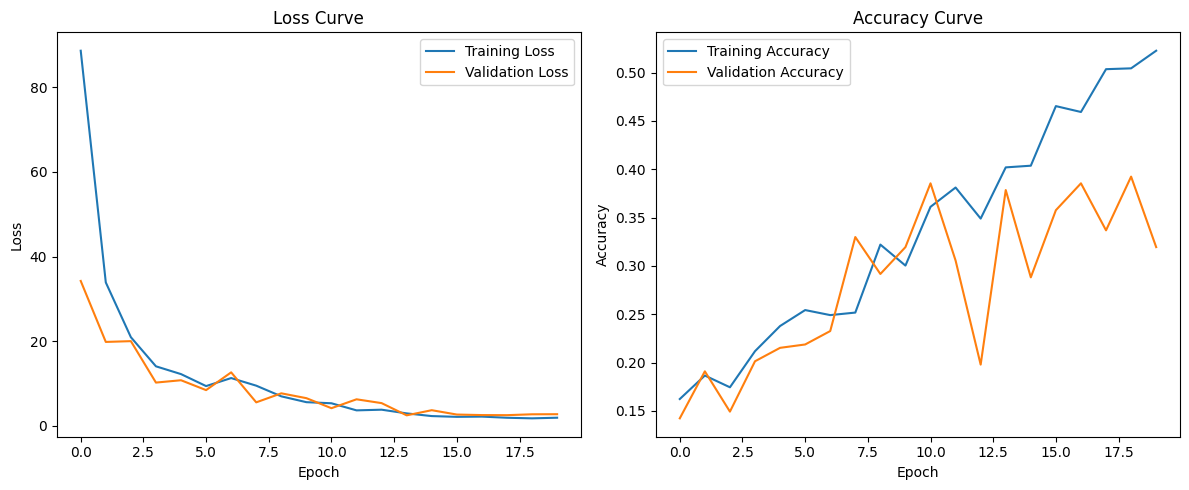

'\nfor lr in param_grid[\'lr\']:\n    for hidden_layer_size in param_grid[\'hidden_size\']:\n        for num_conv_layers in param_grid[\'num_layers\']:\n            for in_channels in param_grid[\'in_channels\']:\n                for out_channels in param_grid[\'out_channels\']:\n                    for kernel_size in param_grid[\'kernel_size\']:\n                        for num_epochs in param_grid[\'num_epochs\']:\n                            print(f"lr: {lr} hidden size: {hidden_layer_size} in_channels: {in_channels}"\n                                  f" out_channels: {out_channels} kernel_size: {kernel_size} num epochs: {num_epochs}")\n                            m = EmotionDetector(num_conv_layers, in_channels, out_channels, kernel_size).to(device)\n                            train_model(m, train_loader, val_loader, num_epochs, lr, device=device)\n                            torch.cuda.empty_cache()\n                            gc.collect()\n                            del m \n'

In [5]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc


def train_model(model, train_loader, val_loader, num_epochs, lr, device='cuda'):
    """
    Train a CNN+LSTM model for emotion recognition with progress bars.

    Args:
        model: PyTorch nn.Module
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        num_epochs: number of epochs
        lr: learning rate
        device: 'cuda' or 'cpu'
    """

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop with tqdm
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            train_loader_iter.set_postfix({'loss': running_loss / total, 'acc': correct / total})

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation loop with tqdm
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_loader_iter = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for val_inputs, val_labels in val_loader_iter:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                val_loss += v_loss.item() * val_inputs.size(0)
                _, val_pred = val_outputs.max(1)
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)

                val_loader_iter.set_postfix({'val_loss': val_loss / val_total, 'val_acc': val_correct / val_total})

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device ", device)

param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],
    'hidden_size': [64, 128, 256],
    'num_layers': [2, 3, 4],
    'in_channels': [1],
    'out_channels': [2],
    'kernel_size': [3, 5],
    'num_epochs': [5]
}

m = EmotionDetector(4, 1, 2, 4).to(device)
checkpoint = train_model(m, train_loader, val_loader, 20, 0.001, device=device)
torch.save(checkpoint, "dataset2_model.pt")

"""
for lr in param_grid['lr']:
    for hidden_layer_size in param_grid['hidden_size']:
        for num_conv_layers in param_grid['num_layers']:
            for in_channels in param_grid['in_channels']:
                for out_channels in param_grid['out_channels']:
                    for kernel_size in param_grid['kernel_size']:
                        for num_epochs in param_grid['num_epochs']:
                            print(f"lr: {lr} hidden size: {hidden_layer_size} in_channels: {in_channels}"
                                  f" out_channels: {out_channels} kernel_size: {kernel_size} num epochs: {num_epochs}")
                            m = EmotionDetector(num_conv_layers, in_channels, out_channels, kernel_size).to(device)
                            train_model(m, train_loader, val_loader, num_epochs, lr, device=device)
                            torch.cuda.empty_cache()
                            gc.collect()
                            del m 
"""

In [56]:
load = iter(train_loader)
feature, label = next(load)
print(feature.shape)

torch.Size([32, 1, 1025, 310])


In [1]:
c = 0
l = []
for name, param in m.named_parameters():
    c+=param.numel()
    l.append(param.numel())
l.sort()
print(l[len(l)//2])
print(l)
print(c)

NameError: name 'm' is not defined

In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()
del m
print("done")

In [81]:
for name, param in m.named_parameters():
    print()
    print(name)
    print(param.flatten().cpu().median())
    print(param.flatten().cpu().std())


conv1.0.weight
tensor(0.0592, grad_fn=<MedianBackward0>)
tensor(0.1483, grad_fn=<StdBackward0>)

conv1.0.bias
tensor(-0.3799, grad_fn=<MedianBackward0>)
tensor(0.2572, grad_fn=<StdBackward0>)

conv2.0.weight
tensor(-0.0322, grad_fn=<MedianBackward0>)
tensor(0.1392, grad_fn=<StdBackward0>)

conv2.0.bias
tensor(-0.1715, grad_fn=<MedianBackward0>)
tensor(0.1821, grad_fn=<StdBackward0>)

conv3.0.weight
tensor(-0.0349, grad_fn=<MedianBackward0>)
tensor(0.1090, grad_fn=<StdBackward0>)

conv3.0.bias
tensor(-0.0573, grad_fn=<MedianBackward0>)
tensor(0.0832, grad_fn=<StdBackward0>)

fc1.weight
tensor(-8.1746e-05, grad_fn=<MedianBackward0>)
tensor(0.0212, grad_fn=<StdBackward0>)

fc1.bias
tensor(-0.0040, grad_fn=<MedianBackward0>)
tensor(0.0328, grad_fn=<StdBackward0>)


In [11]:
checkpoint

EmotionDetector(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 2, kernel_size=(4, 4), stride=(1, 1), padding=same)
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(2, 4, kernel_size=(4, 4), stride=(1, 1), padding=same)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(4, 4), stride=(1, 1), padding=same)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(8, 